In [6]:
import cv2
from scipy import interpolate
import matplotlib.pyplot as plt
import FileManager
import Image_preperation as prep
import numpy as np

def intensity_prob(I, max_I, c=1):
    return c*(1-I/max_I)

def position_prob(Y, Yest, Sigma):
    t = (Y - Yest)**2 / (Sigma**2)
    return ( 1 / (np.sqrt(2*np.pi)*Sigma) ) * np.exp(-t)
    
    
def gap_valley_img(img, Yest, Sigma):
    
    img_copy = np.copy(img)
    h_proj = h_project(img)
    maxI = max(h_proj)
    pIY = np.empty_like(h_proj, dtype= np.float32)
    
    for Y, I in enumerate(h_proj):
        pI = intensity_prob(I,maxI)
        pY = position_prob(Y, Yest, Sigma)
        pIY[Y] = pI * pY
        
    gap = np.argmax(pIY)
    cv2.line(img_copy,(0,gap),(img.shape[1],gap),(255,0,0),10)
    #plt.imshow(img_copy)
    #plt.show()
    
    return np.argmax(pIY), img_copy

def h_project(img):
    
    h_proj = np.sum(img, axis=1)
    y = np.arange(img.shape[0])
    #plt.plot(h_proj, y)
    #plt.show()
    return h_proj
    
def img_splits(img, times):
    
    size, rem = np.divmod(img.shape[1] , times)
    splits = np.arange(0,img.shape[1], size)
    if rem > 0 :
        times += 1

    length = len(splits)
    for i, split in enumerate(splits):
        if i == length - 1:
            yield img[:,split:img.shape[1]-1]
        else:
            yield img[:,split:splits[i+1]]
       
    
def gap_splits(img, times, Yest, Sigma):
    splits = img_splits(img, times)
    gaps = np.empty(times+1)
    gap_size = np.empty(times+1)
    new_img = np.empty((img.shape[0],0))
    for i, split in enumerate(splits):
        gaps[i], split_img = gap_valley_img(split, Yest, Sigma)
        if i == 0:
            gap_size[i] = split_img.shape[0] / 2
        else:
            gap_size[i] = gap_size[i-1] + split_img.shape[0] #laatste gaat niet kloppe
        new_img = np.append(new_img, split_img, axis=1)
        
    #plt.imshow(new_img)
    #plt.show(new_img)
    
    return gaps, gap_size, new_img


def interpolate(img, gaps, gap_size):
    f2 = interp1d(gap_size, gaps, kind='cubic')
    plt.plot(gap_size, gaps, '-', gap_size, f2(gap_size), '--')
    #plt.axis((0, img.shape[1], 0, img.shape[0]))
    plt.show()
    
    
def interpolate2(img, gaps, gap_size):
    #tck = interpolate.splrep(gap_size, gaps, s=0)
    ynew = interpolate.splev(gap_size, gaps, der=0)
    plt.plot(gap_size, gaps, 'x', gap_size, ynew, '--')
    #plt.axis((0, img.shape[1], 0, img.shape[0]))
    plt.show()


    
def gap_detection(img):
    
    h_proj = np.sum(img, axis=1)
    y = np.arange(img.shape[0])
    plt.plot(h_proj, y)
    plt.show()
    

def split(img, times):
    
    size, rem = np.divmod(img.shape[1] , times)
    splits = np.arange(0,img.shape[1], size)
    if rem > 0 :
        times += 1
    img_splitted = np.array((times, img.shape[0], size))
    length = len(splits)
    for i, split in enumerate(splits):
        if i == length - 1:
            img_splitted[i] = img[:,split:img.shape[1]-1
                                 ]
        img_splitted[i] = img[:,split:splits[i+1]]
        
    return img_splitted


def active_contour_match(img, init):
    snake = active_contour(gaussian(img, 3), init, alpha=0.015, beta=10, gamma=0.001)
    return snake
    
    

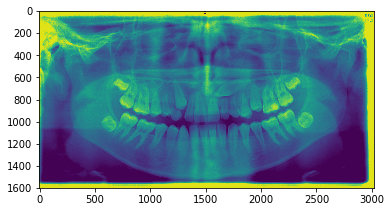

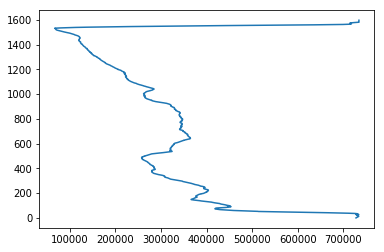

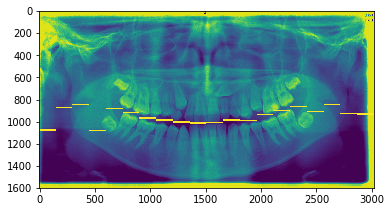

In [8]:
if __name__ == "__main__":
    #main
    
    radiographs = FileManager.load_radiographs()
    radiograph = radiographs[0]
    plt.imshow(radiograph)
    plt.show()

    gap_detection(radiograph)

    img = radiograph
    gaps,gap_size, new_img = gap_splits(img, 20, 900, 400)
    plt.imshow(new_img)
    plt.show()

